<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4a: Predict West Nile Virus

## Part 5 - Modelling and Evaluation

## Contents:
- [Import Data](#Import-Data)
- [Modelling with Data Visualisation](#Modelling-with-Data-Visualisation)
    - [Train Test Split](#Train-Test-Split)
    - [Baseline](#Baseline)
    - [Random Forest](#Random-Forest)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [Logistics Regression](#Logistics-Regression)
    - [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
    - [Gradient Boosting](#Gradient-Boosting)
    - [AdaBoost](#AdaBoost)
- [Evaluation](#Evaluation)
- [Model with Test Dataset](#Model-with-Test-Dataset)

## Import Data

### Import all necessary libraries

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import re
import string
import nltk

#used to check the time elapsed since running
from time import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

#hide warnings
import warnings
warnings.filterwarnings('ignore')

### Import Data from Merged Dataset

In [2]:
%store -r train_merged_df
%store -r test_df
%store -r weather

In [3]:
train_merged_df.head(2)

,date,address,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,...,result_dir,avg_speed,wet_dry,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,...,18,6.5,1,0,1,0,0,0,0,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,...,18,6.5,1,0,0,1,0,0,0,0


## Modelling with Data Visualisation

For the modelling, we will be using the following models:
- [Random Forest](#Random-Forest)
- [Support Vector Classification](#Support-Vector-Classification)
- [Logistic Regression](#Logistic-Regression)
- [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
- [Gradient Boosting](#Gradient-Boosting)
- [AdaBoost (using Decision Tree)](#AdaBoost)

### Train Test Split

In [4]:
# Save the needed features into X
X = train_merged_df.drop(columns=['date','date_1','wnvpresent','address','block','street','trap','addressnumberandstreet',
                                  'addressaccuracy','geometry'], axis=1)

In [5]:
# Save the 'wnvpresent' into y
y = train_merged_df['wnvpresent']

In [6]:
# Print the X shape
X.shape

(10506, 20)

In [7]:
# Print the y shape
y.shape

(10506,)

In [8]:
# Do a train test split of 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)

In [9]:
# Check the X info
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        10506 non-null  float64
 1   longitude                       10506 non-null  float64
 2   month_x                         10506 non-null  int64  
 3   year_x                          10506 non-null  int64  
 4   week_x                          10506 non-null  int64  
 5   yearmonth                       10506 non-null  int64  
 6   station                         10506 non-null  int64  
 7   t_avg                           10506 non-null  float64
 8   precip_total                    10506 non-null  float64
 9   sea_level                       10506 non-null  float64
 10  result_dir                      10506 non-null  int64  
 11  avg_speed                       10506 non-null  float64
 12  wet_dry                         

In [10]:
#scale the X values to ensure the variables are all on the same scale
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

In [11]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

X_train_scale, y_train = sm.fit_resample(X_train_scale, y_train)

### Baseline

The Baseline is the Accuracy score, which is equivalent to the proportion of the majority class, in the event where we predict that all the target values in the test set is equal to 0 (no west nile virus present).

In [12]:
#predicting that all values in the test subset are of one value
y_test.value_counts(normalize=True)

0    0.947652
1    0.052348
Name: wnvpresent, dtype: float64

The Baseline Test Accuracy score is approximately 0.95, indicating that we achieve 95% accuracy if we predict that no west nile virus is present at all regardless of the data collected.

While this is an extremely high score, it is not ideal as the purpose of this project is to correctly identify when the west nile virus is really present and deploy pesticides at those places identified to prevent further spreading of the deadly virus. Predicting that no virus is present regardless of the data collected will defeat the purpose of this project.

Additionally, the high score obtained from this way of prediction is due to the highly imbalanced and skewed dataset. This means the Baseline is extremely biased towards the prediction of having no west nile virus, which makes this a bad evaluation.

Generally speaking, Accuracy is not a good metric to use for evaluation on problems with imbalanced datasets like this.

<b>Therefore, to decide on the best performing model, we will look at the following metrics:
- Area Under Curve (AUC)
- Precision-Recall score
- F1 score
- *Train Accuracy (to check for overfitting)*
- *Test Accuracy (to check for overfitting)*
</b>

We will run different models with tuned hyperparameters to choose the model best suited for this classification problem based on the metrics specified above. The metrics will be explained in more details under the [Evaluation](#Evaluation) section where we will also be comparing the models.

### Random Forest

In [13]:
#run start time in seconds
start = time()

# instantiate random forest
rf = RandomForestClassifier()

# A list of params to be fit into Grid Search CV
rf_params = {'n_estimators': [100, 150, 200], 
             'max_depth': [None, 1, 2, 3, 4, 5]
            }

# instantiate GridSearchCV
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, scoring='roc_auc')

# Fit the data into gridsearch
gs_rf.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')


Time taken to run: 54.86 seconds


In [14]:
# The best params to used for the model
gs_rf_best = gs_rf.best_params_

print('Best Parameters:', gs_rf_best)

Best Parameters: {'max_depth': None, 'n_estimators': 200}


The optimal hyperparameters values for the Random Forest Model found are:
- max_depth = None
- n_estimators = 200

We will run the model once again with this value and pull out the scores required for evaluation.

In [56]:
# Initiate the random forest Model
rf_optimal = RandomForestClassifier(max_depth=None, n_estimators=200)

# Fit data into the Model
rf_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(rf_optimal)

# Use model to predict classifcation
rf_y_pred = rf_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
rf_train_accu = cross_val_score(rf_optimal, X_train_scale, y_train, cv=5).mean()
print('\nRandom Forest Train Accuracy:', rf_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
rf_test_accu = cross_val_score(rf_optimal, X_test_scale, y_test, cv=5).mean()
print('Random Forest Test Accuracy:', rf_test_accu)

# Print classification report for y_pred compared to y_test
rf_report = classification_report(y_test, rf_y_pred)
print('\nRandom Forest Classification Report:\n', rf_report)

# Print roc_auc_score for y_test
rf_auc = roc_auc_score(y_test, rf_optimal.predict_proba(X_test_scale)[:,1])
print('Random Forest AUC value:', rf_auc)


RandomForestClassifier(n_estimators=200)

Random Forest Train Accuracy: 0.9396558318777641
Random Forest Test Accuracy: 0.9381369959499913

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      2987
           1       0.22      0.33      0.26       165

    accuracy                           0.90      3152
   macro avg       0.59      0.63      0.61      3152
weighted avg       0.92      0.90      0.91      3152

Random Forest AUC value: 0.80538900893772


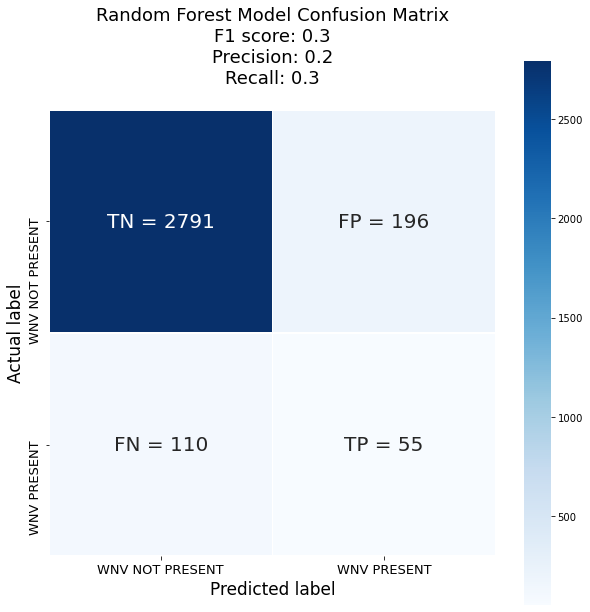

In [57]:
# random forest confusion matrix
rf_cmatrix = confusion_matrix(y_test, rf_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
rf_prec, rf_recall, rf_f1, rf_supp = score(y_test, rf_y_pred)

# visualisation of confusion matrix
rf_modified_cm = []
for index,value in enumerate(rf_cmatrix):
    if index == 0:
        rf_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        rf_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(rf_cmatrix, annot=np.array(rf_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT']
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Random Forest Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(rf_f1[1])+'\n'
          +'Precision: {:.1f}'.format(rf_prec[1])+'\n'
          +'Recall: {:.1f}'.format(rf_recall[1])+'\n', size = 18);
plt.tick_params(labelsize=13);

plt.savefig('../images/rf_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

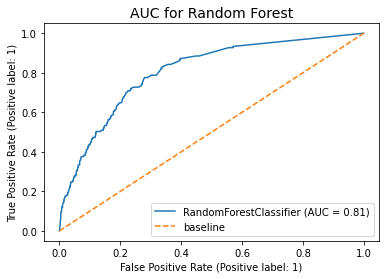

In [58]:
#get the area under curve score
plot_roc_curve(rf_optimal, X_test_scale, y_test)

plt.title('AUC for Random Forest', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.savefig('../images/rf_auc', bbox_inches="tight", dpi=300)

plt.show();

### Support Vector Classifier

In [18]:
#run start time in seconds
start = time()

# Instantiate Support Vector Classifier
svc = SVC(max_iter=10000)

# C values to GridSearch over
svc_params = {"C": np.linspace(0.0001, 2, 10), 
              "kernel": ['rbf', 'poly', 'linear']
             }

# Cross validation ensures each fold of dataset has the same proportion of observations with a given label
svc_cv = StratifiedKFold(n_splits=5, shuffle=True)

# Instantiate GridSearchCV
gs_svc = GridSearchCV(svc, svc_params, cv=svc_cv, scoring='roc_auc')

# fit data into model
gs_svc.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')

Time taken to run: 746.3 seconds


In [19]:
# Save Support Vector Classifier cv results as a DataFrame
svc_df = pd.DataFrame(gs_svc.cv_results_)
svc_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.117213,0.217424,3.133532,0.026641,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",0.812639,0.814238,0.802319,0.810585,0.795048,0.806966,0.007236,19
1,5.501456,0.036124,1.078066,0.001699,0.0001,poly,"{'C': 0.0001, 'kernel': 'poly'}",0.793502,0.791846,0.791241,0.788343,0.777543,0.788495,0.005724,20
2,4.792234,0.025130,0.885521,0.001315,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.761544,0.763722,0.758250,0.767291,0.748293,0.759820,0.006471,23
3,4.702947,0.075522,1.616263,0.015425,0.222311,rbf,"{'C': 0.2223111111111111, 'kernel': 'rbf'}",0.903895,0.894376,0.901998,0.898930,0.888463,0.897532,0.005561,9
4,4.026849,0.044953,0.626124,0.004804,0.222311,poly,"{'C': 0.2223111111111111, 'kernel': 'poly'}",0.877972,0.870812,0.876750,0.878105,0.867054,0.874139,0.004439,18
5,4.295495,0.016603,0.623759,0.003484,0.222311,linear,"{'C': 0.2223111111111111, 'kernel': 'linear'}",0.784189,0.777251,0.784598,0.779894,0.760139,0.777214,0.008966,21
6,4.443194,0.017238,1.497301,0.010629,0.444522,rbf,"{'C': 0.4445222222222222, 'kernel': 'rbf'}",0.910675,0.902785,0.910436,0.908124,0.900051,0.906414,0.004264,8
7,3.874009,0.066069,0.574143,0.005098,0.444522,poly,"{'C': 0.4445222222222222, 'kernel': 'poly'}",0.883056,0.876603,0.881476,0.884887,0.872953,0.879795,0.004391,17
8,3.997656,0.028954,0.619809,0.003558,0.444522,linear,"{'C': 0.4445222222222222, 'kernel': 'linear'}",0.773444,0.765597,0.779486,0.771623,0.761487,0.770327,0.006258,22
9,4.232962,0.019185,1.429957,0.013253,0.666733,rbf,"{'C': 0.6667333333333333, 'kernel': 'rbf'}",0.913921,0.907194,0.914154,0.910364,0.906089,0.910345,0.003327,7


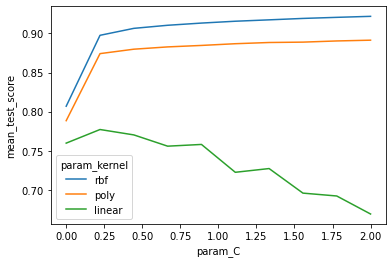

In [20]:
# Plotting to show how C values affect test auc
sns.lineplot(x="param_C", y="mean_test_score", data=svc_df, hue= "param_kernel");

In [21]:
# The best params to use for the model
gs_svc_best = gs_svc.best_params_

print('Best Parameters:', gs_svc_best)

Best Parameters: {'C': 2.0, 'kernel': 'rbf'}


The optimal hyperparameter value for the Support Vector Classifier Model found is:
- C = 2.0
- kernel = rbf

We will run the model once again with this value and pull out the scores required for evaluation.

In [59]:
# Initiate the Support Vector Classifier Model
svc_optimal = SVC(max_iter=10000, C=2.0, kernel='rbf', probability=True)

# Fit data into the Model
svc_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(svc_optimal)

# Use model to predict classifcation
svc_y_pred = svc_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
svc_train_accu = cross_val_score(svc_optimal, X_train_scale, y_train, cv=5).mean()
print('\nSupport Vector Classifier Train Accuracy:', svc_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
svc_test_accu = cross_val_score(svc_optimal, X_test_scale, y_test, cv=5).mean()
print('Support Vector Classifier Test Accuracy:', svc_test_accu)

# Print classification report for y_pred compared to y_test
svc_report = classification_report(y_test, svc_y_pred)
print('\nSupport Vector Classifier Classification Report:\n', svc_report)

# Print roc_auc_score for y_test
svc_auc = roc_auc_score(y_test, svc_optimal.predict_proba(X_test_scale)[:,1])
print('Support Vector Classifier AUC value:', svc_auc)


SVC(C=2.0, max_iter=10000, probability=True)

Support Vector Classifier Train Accuracy: 0.8559134977470209
Support Vector Classifier Test Accuracy: 0.9476522526601766

Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      2987
           1       0.16      0.73      0.26       165

    accuracy                           0.78      3152
   macro avg       0.57      0.76      0.57      3152
weighted avg       0.94      0.78      0.84      3152

Support Vector Classifier AUC value: 0.8395562589402563


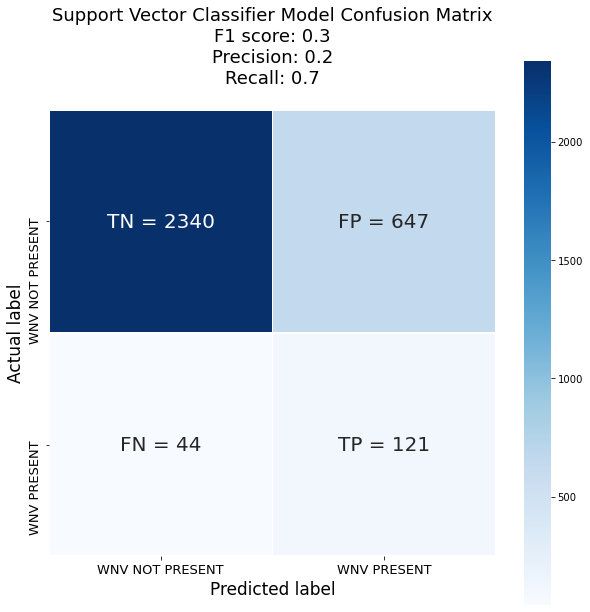

In [60]:
# Support Vector Classifier confusion matrix
svc_cmatrix = confusion_matrix(y_test, svc_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
svc_prec, svc_recall, svc_f1, svc_supp = score(y_test, svc_y_pred)

# visualisation of confusion matrix
svc_modified_cm = []
for index,value in enumerate(svc_cmatrix):
    if index == 0:
        svc_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        svc_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(svc_cmatrix, annot=np.array(svc_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Support Vector Classifier Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(svc_f1[1])+'\n'
          +'Precision: {:.1f}'.format(svc_prec[1])+'\n'
          +'Recall: {:.1f}'.format(svc_recall[1])+'\n', size = 18);
plt.tick_params(labelsize= 13);

plt.savefig('../images/svc_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

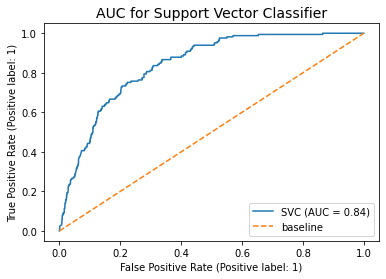

In [61]:
#get the area under curve score
plot_roc_curve(svc_optimal, X_test_scale, y_test)

plt.title('AUC for Support Vector Classifier', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend(loc=4);

plt.savefig('../images/svc_auc', bbox_inches="tight", dpi=300)

plt.show();

### Logistics Regression

In [25]:
#run start time in seconds
start = time()

# instantiate logistic regression
lr = LogisticRegression(max_iter=10_000)

# A list of params to be fit into Grid Search CV
lr_params = {'solver': ['lbfgs', 'newton-cg', 'saga'], 
             'penalty': [None, 'l2'], 
             'C': np.linspace(0.01, 1, 5)
            }

# instantiate GridSearchCV
gs_lr = GridSearchCV(lr, param_grid=lr_params, cv=5, scoring='roc_auc')

# Fit the data into gridsearch
gs_lr.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')


Time taken to run: 38.68 seconds


In [26]:
# The best params to used for the model
gs_lr_best = gs_lr.best_params_

print('Best Parameters:', gs_lr_best)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


The optimal hyperparameters values for the Logistic Regression Model found are:
- C = 0.01
- penalty = l2
- solver = lbfgs

We will run the model once again with this value and pull out the scores required for evaluation.

In [62]:
# Initiate the logistic regression Model
lr_optimal = LogisticRegression(max_iter=10_000, C=0.01, penalty='l2', solver='lbfgs')

# Fit data into the Model
lr_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(lr_optimal)

# Use model to predict classifcation
lr_y_pred = lr_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
lr_train_accu = cross_val_score(lr_optimal, X_train_scale, y_train, cv=5).mean()
print('\nLogistic Regression Train Accuracy:', lr_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
lr_test_accu = cross_val_score(lr_optimal, X_test_scale, y_test, cv=5).mean()
print('Logistic Regression Test Accuracy:', lr_test_accu)

# Print classification report for y_pred compared to y_test
lr_report = classification_report(y_test, lr_y_pred)
print('\nLogistic Regression Classification Report:\n', lr_report)

# Print roc_auc_score for y_test
lr_auc = roc_auc_score(y_test, lr_optimal.predict_proba(X_test_scale)[:,1])
print('Logistic Regression AUC value:', lr_auc)


LogisticRegression(C=0.01, max_iter=10000)

Logistic Regression Train Accuracy: 0.7149829166879018
Logistic Regression Test Accuracy: 0.9476522526601766

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.64      0.78      2987
           1       0.11      0.76      0.19       165

    accuracy                           0.65      3152
   macro avg       0.54      0.70      0.48      3152
weighted avg       0.93      0.65      0.75      3152

Logistic Regression AUC value: 0.7683852248632965


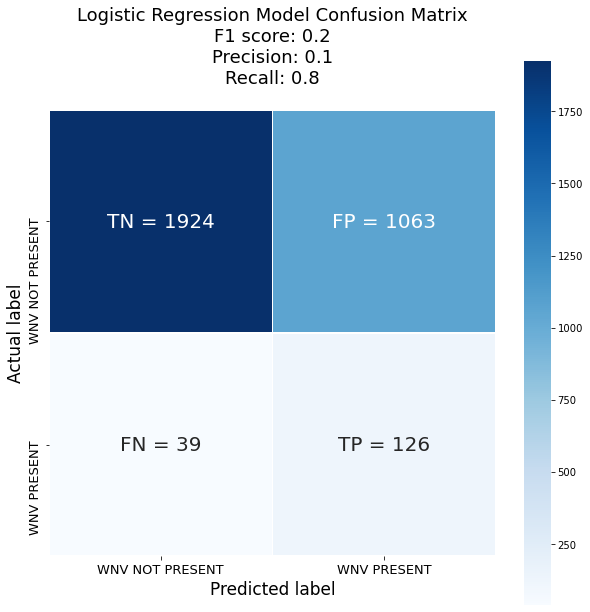

In [63]:
# logistic regression confusion matrix
lr_cmatrix = confusion_matrix(y_test, lr_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
lr_prec, lr_recall, lr_f1, lr_supp = score(y_test, lr_y_pred)

# visualisation of confusion matrix
lr_modified_cm = []
for index,value in enumerate(lr_cmatrix):
    if index == 0:
        lr_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        lr_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(lr_cmatrix, annot=np.array(lr_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Logistic Regression Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(lr_f1[1])+'\n'
          +'Precision: {:.1f}'.format(lr_prec[1])+'\n'
          +'Recall: {:.1f}'.format(lr_recall[1])+'\n', size = 18);
plt.tick_params(labelsize= 13);

plt.savefig('../images/logreg_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

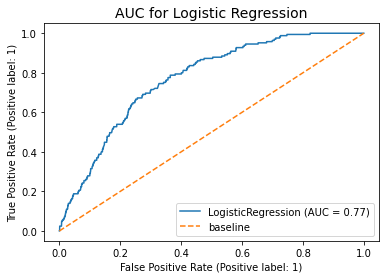

In [64]:
#get the area under curve score
plot_roc_curve(lr_optimal, X_test_scale, y_test)

plt.title('AUC for Logistic Regression', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.savefig('../images/logreg_auc', bbox_inches="tight", dpi=300)

plt.show();

### Bernoulli Naive Bayes

In [30]:
#run start time in seconds
start = time()

# instantiate bernoulli naive bayes
bernNB = BernoulliNB()

# A list of params to be fit into Grid Search CV
bernNB_params = {'alpha': list(np.linspace(0.01, 2.0, 5))}

# instantiate GridSearchCV
gs_bernNB = GridSearchCV(bernNB, param_grid=bernNB_params, cv=5, scoring='roc_auc')

# Fit the data into gridsearch
gs_bernNB.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')


Time taken to run: 0.17 seconds


In [31]:
# The best params to used for the model
gs_bernNB_best = gs_bernNB.best_params_

print('Best Parameters:', gs_bernNB_best)

Best Parameters: {'alpha': 0.01}


The optimal hyperparameter value for the Bernoulli Naive Bayes Model found is:
- alpha = 0.01

We will run the model once again with this value and pull out the scores required for evaluation.

In [32]:
# Initiate the bernoulli naive bayes Model
bernNB_optimal = BernoulliNB(alpha=0.01)

# Fit data into the Model
bernNB_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(bernNB_optimal)

# Use model to predict classifcation
bernNB_y_pred = bernNB_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
bernNB_train_accu = cross_val_score(bernNB_optimal, X_train_scale, y_train, cv=5).mean()
print('\nBernoulli Naive Bayes Train Accuracy:', bernNB_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
bernNB_test_accu = cross_val_score(bernNB_optimal, X_test_scale, y_test, cv=5).mean()
print('Bernoulli Naive Bayes Test Accuracy:', bernNB_test_accu)

# Print classification report for y_pred compared to y_test
bernNB_report = classification_report(y_test, bernNB_y_pred)
print('\nBernoulli Naive Bayes Classification Report:\n', bernNB_report)

# Print roc_auc_score for y_test
bernNB_auc = roc_auc_score(y_test, bernNB_optimal.predict_proba(X_test_scale)[:,1])
print('Bernoulli Naive Bayes AUC value:', bernNB_auc)


BernoulliNB(alpha=0.01)

Bernoulli Naive Bayes Train Accuracy: 0.6951772139452541
Bernoulli Naive Bayes Test Accuracy: 0.9447976253364526

Bernoulli Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.64      0.77      2987
           1       0.10      0.77      0.18       165

    accuracy                           0.64      3152
   macro avg       0.54      0.70      0.48      3152
weighted avg       0.93      0.64      0.74      3152

Bernoulli Naive Bayes AUC value: 0.7637875237138712


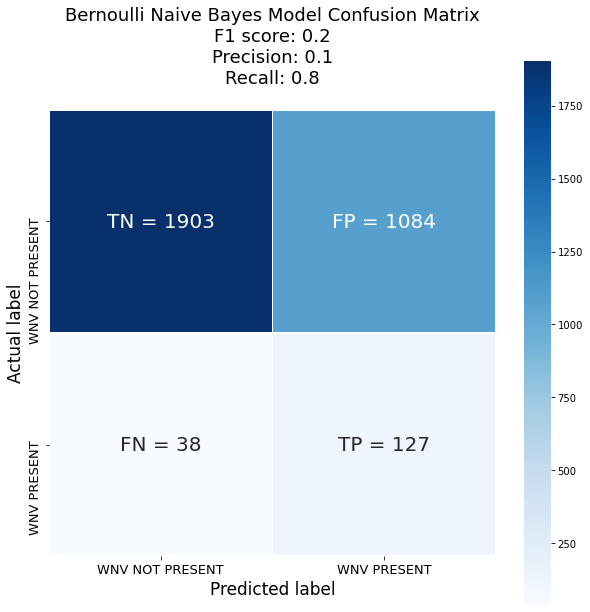

In [33]:
# bernoulli naive bayes confusion matrix
bernNB_cmatrix = confusion_matrix(y_test, bernNB_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
bernNB_prec, bernNB_recall, bernNB_f1, bernNB_supp = score(y_test, bernNB_y_pred)

# visualisation of confusion matrix
bernNB_modified_cm = []
for index,value in enumerate(bernNB_cmatrix):
    if index == 0:
        bernNB_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        bernNB_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(bernNB_cmatrix, annot=np.array(bernNB_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Bernoulli Naive Bayes Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(bernNB_f1[1])+'\n'
          +'Precision: {:.1f}'.format(bernNB_prec[1])+'\n'
          +'Recall: {:.1f}'.format(bernNB_recall[1])+'\n', size = 18);
plt.tick_params(labelsize= 13)

plt.savefig('../images/bernNB_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

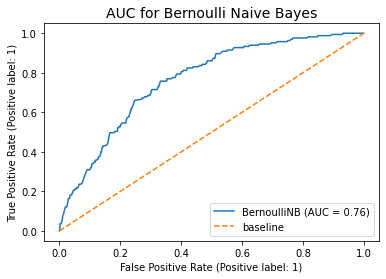

In [34]:
#get the area under curve score
plot_roc_curve(bernNB_optimal, X_test_scale, y_test)

plt.title('AUC for Bernoulli Naive Bayes', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.savefig('../images/bernNB_auc', bbox_inches="tight", dpi=300)

plt.show();

### Gradient Boosting

In [35]:
#run start time in seconds
start = time()

# To do GridSearchCV to find out whats the best param for roc_auc_score
gboost = GradientBoostingClassifier()

# A list of params to be fit into Grid Search CV
gboost_params = {"n_estimators":[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]}

# Done a GridSearchCV
gs_gboost = GridSearchCV (gboost, gboost_params, cv = 5, scoring='roc_auc')

# Fit the data into model
gs_gboost.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')

Time taken to run: 55.22 seconds


In [36]:
# The best params to used for the model
gs_gboost_best = gs_gboost.best_params_

print('Best Parameters:', gs_gboost_best)

Best Parameters: {'n_estimators': 200}


The optimal hyperparameter value for the Gradient Boosting Model found is:
- n_estimators = 200

We will run the model once again with this value and pull out the scores required for evaluation.

In [65]:
# Initiate the Gradient Boosting Model
gboost_optimal = GradientBoostingClassifier(n_estimators = 200)

# Fit data into the Model
gboost_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(gboost_optimal)

# Use model to predict classifcation
gboost_y_pred = gboost_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
gboost_train_accu = cross_val_score(gboost_optimal, X_train_scale, y_train, cv=5).mean()
print('\nGradient Boost Train Accuracy:', gboost_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
gboost_test_accu = cross_val_score(gboost_optimal, X_test_scale, y_test, cv=5).mean()
print('Gradient Boost Test Accuracy:', gboost_test_accu)

# Print classification report for y_pred compared to y_test
gboost_report = classification_report(y_test, gboost_y_pred)
print('\nGradient Boost Classification Report:\n', gboost_report)

# Print roc_auc_score for y_test
gboost_auc = roc_auc_score(y_test, gboost_optimal.predict_proba(X_test_scale)[:,1])
print('Gradient Boost AUC value:', gboost_auc)

GradientBoostingClassifier(n_estimators=200)

Gradient Boost Train Accuracy: 0.9004762323948192
Gradient Boost Test Accuracy: 0.9422599552235053

Gradient Boost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      2987
           1       0.18      0.59      0.27       165

    accuracy                           0.83      3152
   macro avg       0.58      0.72      0.59      3152
weighted avg       0.93      0.83      0.87      3152

Gradient Boost AUC value: 0.8474764383033551


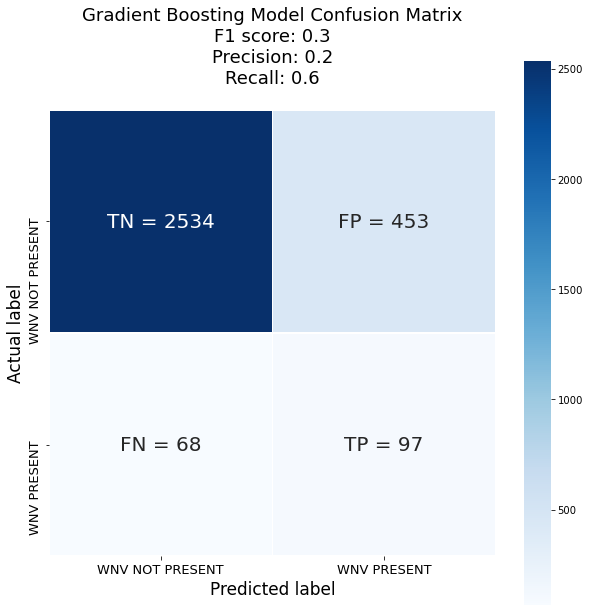

In [66]:
# gradient boosting confusion matrix
gboost_cmatrix = confusion_matrix(y_test, gboost_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
gboost_prec, gboost_recall, gboost_f1, gboost_supp = score(y_test, gboost_y_pred)

# visualisation of confusion matrix
gboost_modified_cm = []
for index,value in enumerate(gboost_cmatrix):
    if index == 0:
        gboost_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        gboost_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(gboost_cmatrix, annot=np.array(gboost_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Gradient Boosting Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(gboost_f1[1])+'\n'
          +'Precision: {:.1f}'.format(gboost_prec[1])+'\n'
          +'Recall: {:.1f}'.format(gboost_recall[1])+'\n', size = 18);
plt.tick_params(labelsize= 13)

plt.savefig('../images/gboost_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

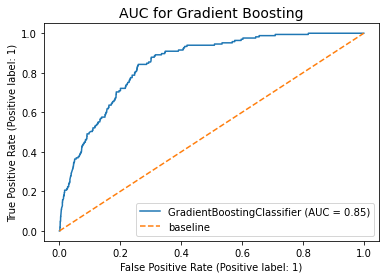

In [67]:
#get the area under curve score
plot_roc_curve(gboost_optimal, X_test_scale, y_test)

plt.title('AUC for Gradient Boosting', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.savefig('../images/gboost_auc', bbox_inches="tight", dpi=300)

plt.show();

### AdaBoost

In [40]:
#run start time in seconds
start = time()

# instantiate AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# set params to tune in gridsearchcv
ada_params = {'n_estimators': [20, 40, 80, 120], 
              'learning_rate': [.8, .9, 1], 
              'base_estimator__max_depth': [1, 3, 5]
             }

# gridsearchcv to find optimal hyperparameters
gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=5, scoring='roc_auc')

# fit gridsearchcv to training data
gs_ada.fit(X_train_scale, y_train)

# amount of time taken to run in seconds
time_taken = time() - start
print('Time taken to run:', round(time_taken, 2), 'seconds')


Time taken to run: 181.17 seconds


In [41]:
# get best optimised parameters
gs_ada_params = gs_ada.best_params_

print('Best Parameters:', gs_ada_params)

Best Parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.8, 'n_estimators': 120}


The optimal hyperparameters for the AdaBoost Model found seems to be:
- DecisionTreeClassifier(max_depth = 1)
- learning_rate = 0.8
- n_estimators = 80

We will run the model once again with this value and pull out the scores required for evaluation.

In [76]:
# Initiate the AdaBoost Model
ada_optimal = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                                 learning_rate=0.8, 
                                 n_estimators=80
                                )

# Fit data into the Model
ada_optimal.fit(X_train_scale, y_train)

# Print the model name to ensure that it works.
print(ada_optimal)

# Use model to predict classifcation
ada_y_pred = ada_optimal.predict(X_test_scale)

# get mean Train Accuracy using cross-Validation with number of folds = 5
ada_train_accu = cross_val_score(ada_optimal, X_train_scale, y_train, cv=5).mean()
print('\nAdaBoost Train Accuracy:', ada_train_accu)

# get mean Test Accuracy using cross-Validation with number of folds = 5
ada_test_accu = cross_val_score(ada_optimal, X_test_scale, y_test, cv=5).mean()
print('nAdaBoost Test Accuracy:', ada_test_accu)

# Print classification report for y_pred compared to y_test
ada_report = classification_report(y_test, ada_y_pred)
print('\nAdaBoost Classification Report:\n', ada_report)

# Print roc_auc_score for y_test
ada_auc = roc_auc_score(y_test, ada_optimal.predict_proba(X_test_scale)[:,1])
print('AdaBoost AUC value:', ada_auc)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=80)

AdaBoost Train Accuracy: 0.8340999588682646
nAdaBoost Test Accuracy: 0.9476522526601766

AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      2987
           1       0.16      0.75      0.26       165

    accuracy                           0.78      3152
   macro avg       0.57      0.76      0.57      3152
weighted avg       0.94      0.78      0.84      3152

AdaBoost AUC value: 0.8422933722900244


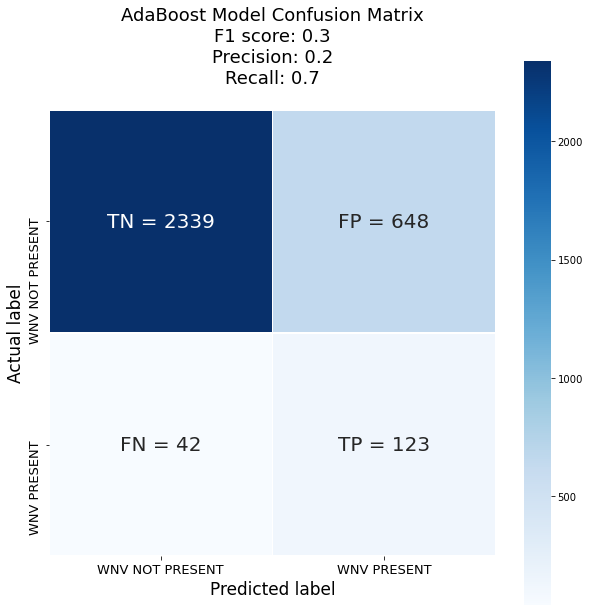

In [77]:
# AdaBoost confusion matrix
ada_cmatrix = confusion_matrix(y_test, ada_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
ada_prec, ada_recall, ada_f1, ada_supp = score(y_test, ada_y_pred)

# visualisation of confusion matrix
ada_modified_cm = []
for index,value in enumerate(ada_cmatrix):
    if index == 0:
        ada_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        ada_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(ada_cmatrix, annot=np.array(ada_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('AdaBoost Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(ada_f1[1])+'\n'
          +'Precision: {:.1f}'.format(ada_prec[1])+'\n'
          +'Recall: {:.1f}'.format(ada_recall[1])+'\n', size = 18);
plt.tick_params(labelsize= 13);

plt.savefig('../images/ada_confusion_matrix', bbox_inches="tight", dpi=300)

plt.show();

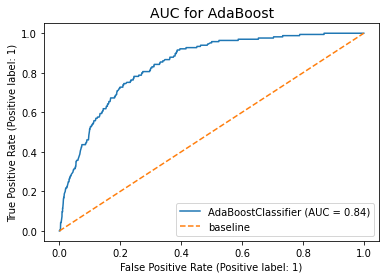

In [78]:
# get the area under curve score
plot_roc_curve(ada_optimal, X_test_scale, y_test)

plt.title('AUC for AdaBoost', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.savefig('../images/ada_auc', bbox_inches="tight", dpi=300)

plt.show();

## Evaluation

Recall that the presence of the west nile virus is classified as such:

|Presence of West Nile Virus|Numerical Value in Dataframes|Class|
|:---:|:---:|:---:|
|**West Nile Virus present**|1|Positive|
|**West Nile Virus not present**|0|Negative|

The metrics that we will use to decide the best model are:
- Area Under Curve (AUC)
- F1 score
- *Train Accuracy (to check for overfitting)*
- *Test Accuracy (to check for overfitting)*

#### Area Under Curve (AUC)

AUC is the area under the Receiver Operating Characteristics (ROC) curve, with False Positive Rate (FPR) on the x-axis and True Positive Rate (TPR) on the y-axis. The AUC score will give us an overall measure of the performance of our classifier. The AUC value lies between 0.5 to 1 where 0.5 denotes a bad classifer and 1 denotes an excellent classifier.

A high AUC value indicates that our model is generally good at distinguishing between the Positive (west nile virus present) and Negative (west nile virus not present) classes. **Ideally, we would want a high AUC.**

#### Precision-Recall scores

$$Precision = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

**Precision** is the ratio of True Positives to All Predicted Positives. It means that of all the Positive predictions made by the model, what percentage of this is actually correct.

Put simply in the context of this project, the higher the Precision score, the higher the number of places that are predicted as having the west nile virus actually does indeed have the west nile virus present.



$$Recall = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$

**Recall** is the ratio of True Positives to All Actual Positives. It shows the percentage of correctly classified Positive predictions by the model against all the positives in the dataset.

Put simply in the context of this project, the higher the Recall score, the higher the number of places with actual west nile virus is correctly classified by the model as having the west nile virus.

*There is usually a trade-off when it comes to Precision and Recall scores depending on the threshold that we set and what kind of prediction we want to prioritise. In this case, we would rather classify a larger number of areas as having the west nile virus (which will increase False Positives) as the alternative to this might cause further spreading of the virus and lead to fatalities.*

**Hence, we would prefer higher Recall at the expense of a lower Precision in order to reduce the chances of misclassifying places that has west nile virus as not having the virus (reducing False Negatives).**

#### F1 score

$$F1 score  =  2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}}$$

The F1 score is the weighted average of the Precision-Recall scores. It will be used to give a better perspective of which model performs the best. 

When there are 2 or more models with similar Precision-Recall scores and a clear answer of which model is better cannot be derived just by comparing the Precision-Recall scores themselves, we will use the F1 score to help us to decide on which model to choose.

An F1 score of 0 means the model is as bad as it can get and a score of 1 means the model is perfect. **When comparing the F1 score, we want it to be as high as possible.**

#### Train and Test Accuracy

$$Accuracy = \frac{\text{True Positives + True Negatives}}{\text{Total Predictions}}$$

When we analysed our [Baseline](#Baseline) Model, we noted that the Accuracy score is not a good metric to use when evaluating extremely imbalanced datasets like the one used in this project.

This is mainly due to the fact that many models are designed with the assumption that the datasets used will be balanced [(source)](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/).

The Accuracy score gives an overview of how accurate the model is in predicting both the majority and the minority classes combined.

The model, highly trained on the majority class and insufficiently trained on the minority class, has not learnt enough about the minority class to be able to predict it accurately, but is highly accurate in predicting the majority class. 

Therefore, it is likely that the Accuracy score returned is still a high value due to the high number of correct predictions of the majority class. <b>This means the Accuracy score actually masks the model's inability to correctly classify the minority class and is misleading in cases of extremely imbalanced datasets like this.</b>

For this reason, we will only compare the Train Accuracy with the Test Accuracy within each model to determine whether the model is overfitted.

In [79]:
print('Random Forest\n' + 'AUC: ', rf_auc, '\nPrecision:', rf_prec[1], '\nRecall:', rf_recall[1], 
      '\nF1 score:', rf_f1[1], '\nTrain Accuracy:', rf_train_accu, '\nTest Accuracy:', rf_test_accu)

print('\nSupport Vector Classification\n' + 'AUC: ', svc_auc, '\nPrecision:', svc_prec[1], '\nRecall:', svc_recall[1], 
      '\nF1 score:', svc_f1[1], '\nTrain Accuracy:', svc_train_accu, '\nTest Accuracy:', svc_test_accu)

print('\nLogistic Regression\n' + 'AUC: ', lr_auc, '\nPrecision:', lr_prec[1], '\nRecall:', lr_recall[1], 
      '\nF1 score:', lr_f1[1], '\nTrain Accuracy:', lr_train_accu, '\nTest Accuracy:', lr_test_accu)

print('\nBernoulli Naive Bayes\n' + 'AUC: ', bernNB_auc, '\nPrecision:', bernNB_prec[1], '\nRecall:', bernNB_recall[1], 
      '\nF1 score:', bernNB_f1[1], '\nTrain Accuracy:', bernNB_train_accu, '\nTest Accuracy:', bernNB_test_accu)

print('\nGradient Boosting\n' + 'AUC: ', gboost_auc, '\nPrecision:', gboost_prec[1], '\nRecall:', gboost_recall[1], 
      '\nF1 score:', gboost_f1[1], '\nTrain Accuracy:', gboost_train_accu, '\nTest Accuracy:', gboost_test_accu)

print('\nAdaBoost\n' + 'AUC: ', ada_auc, '\nPrecision:', ada_prec[1], '\nRecall:', ada_recall[1], 
      '\nF1 score:', ada_f1[1], '\nTrain Accuracy:', ada_train_accu, '\nTest Accuracy:', ada_test_accu)


Random Forest
AUC:  0.80538900893772 
Precision: 0.21912350597609562 
Recall: 0.3333333333333333 
F1 score: 0.2644230769230769 
Train Accuracy: 0.9396558318777641 
Test Accuracy: 0.9381369959499913

Support Vector Classification
AUC:  0.8395562589402563 
Precision: 0.15755208333333334 
Recall: 0.7333333333333333 
F1 score: 0.25937834941050375 
Train Accuracy: 0.8559134977470209 
Test Accuracy: 0.9476522526601766

Logistic Regression
AUC:  0.7683852248632965 
Precision: 0.10597140454163162 
Recall: 0.7636363636363637 
F1 score: 0.1861152141802068 
Train Accuracy: 0.7149829166879018 
Test Accuracy: 0.9476522526601766

Bernoulli Naive Bayes
AUC:  0.7637875237138712 
Precision: 0.10487200660611065 
Recall: 0.7696969696969697 
F1 score: 0.18459302325581398 
Train Accuracy: 0.6951772139452541 
Test Accuracy: 0.9447976253364526

Gradient Boosting
AUC:  0.8474764383033551 
Precision: 0.17636363636363636 
Recall: 0.5878787878787879 
F1 score: 0.2713286713286713 
Train Accuracy: 0.90047623239481

|Different Model|AUC|Precision|Recall|F1-score|Train Accuracy|Test Accuracy|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**Baseline**|-|-|-|-|-|0.950|
|**Random Forest**|0.805|0.219|0.333|0.264|0.940|0.938|
|**Support Vector Classification**|0.840|0.158|0.733|0.259|0.856|0.948|
|**Logistics Regression**|0.768|0.106|0.764|0.186|0.715|0.948|
|**Bernoulli Naive Bayes**|0.764|0.105|0.770|0.185|0.695|0.945|
|**Gradient Boosting**|**0.847**|0.176|0.588|**0.271**|0.900|0.942|
|**AdaBoost**|0.842|0.160|0.745|0.263|0.834|0.948|


In evaluating our models, the priority of metrics is as follows:
1. AUC
2. F1 score
3. Train-Test Accuracy

Firstly, we look at AUC score, because the Kaggle competition uses AUC score as the only metric to rank the submissions. And AUC gives us the overall measure of performance of our classifier. By analogy, the higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

Secondly, we look at the F1 score, which gives us a balance perspective on the precision-recall score performance. A higher F1 score means the combination of precision-recall of the models gives the better performance.

Lastly, we look at the difference between train accuracy and test accuracy. 

If train accuracy > test accuracy, there is overfitting occurs.

If train accuracy < test accuracy, there is underfitting occurs.

It's the most optimum when the difference between train accuracy and test accuracy is smaller, indicating the overfitting/underfitting is less severe.

**Based on the above metrics, Gradient Boosting model is chosen.**

This is because Gradient Boosting model have the highest AUC score out of all models, as well as having the highest F1 score out of all models. With regards to the difference between train accuracy and test accuracy, Gradient Boosting have train accuracy < test accuracy, hence it is underfitting. However, the difference is ~0.05, hence the underfitting is not that severe compared to other models.

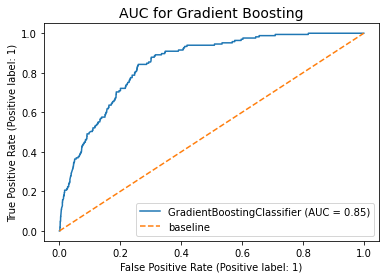

In [80]:
#get the area under curve score
plot_roc_curve(gboost_optimal, X_test_scale, y_test)

plt.title('AUC for Gradient Boosting', fontsize=14)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend();

plt.show();

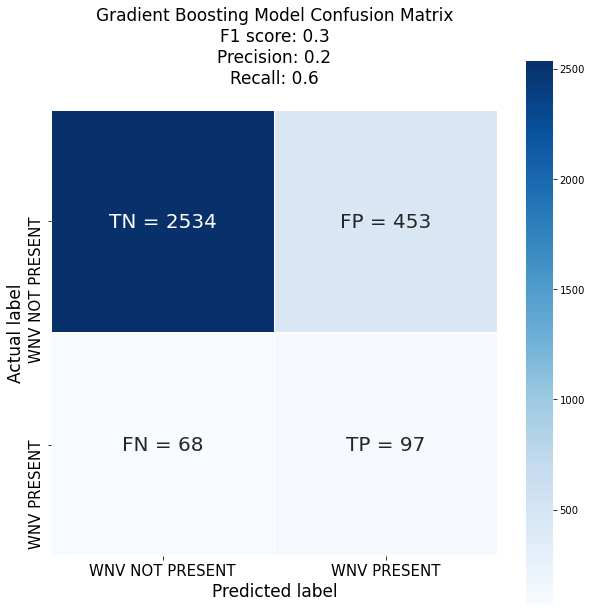

In [81]:
# gradient boosting confusion matrix
gboost_cmatrix = confusion_matrix(y_test, gboost_y_pred)

# pull out score of individual classification metrics
# returns 2 values (1 for each class) --> minority class' value is what we want (index 1)
gboost_prec, gboost_recall, gboost_f1, gboost_supp = score(y_test, gboost_y_pred)

# visualisation of confusion matrix
gboost_modified_cm = []
for index,value in enumerate(gboost_cmatrix):
    if index == 0:
        gboost_modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        gboost_modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

plt.figure(figsize=(10,10))
sns.heatmap(gboost_cmatrix, annot=np.array(gboost_modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            yticklabels = ['WNV NOT PRESENT', 'WNV PRESENT'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Gradient Boosting Model Confusion Matrix\n'
          +'F1 score: {:.1f}'.format(gboost_f1[1])+'\n'
          +'Precision: {:.1f}'.format(gboost_prec[1])+'\n'
          +'Recall: {:.1f}'.format(gboost_recall[1])+'\n', size = 17);
plt.tick_params(labelsize= 15)


## Model with Test Dataset

In [82]:
# merging test and weather datasets
test_df['station'] = test_df['latitude'].map(lambda x:1 if x >=41.85 else 2)

test_df['date'] = pd.to_datetime(test_df['date'])

test_merged_df = test_df.merge(weather, how='left', on=['date','station'])

test_merged_df = pd.get_dummies(columns=['species'], drop_first=True, data = test_merged_df)

test_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              116293 non-null  int64         
 1   date                            116293 non-null  datetime64[ns]
 2   address                         116293 non-null  object        
 3   block                           116293 non-null  int64         
 4   street                          116293 non-null  object        
 5   trap                            116293 non-null  object        
 6   addressnumberandstreet          116293 non-null  object        
 7   latitude                        116293 non-null  float64       
 8   longitude                       116293 non-null  float64       
 9   addressaccuracy                 116293 non-null  int64         
 10  date_1                          116293 non-null  datetim

In [83]:
# cleaning up merged dataframe columns
# drop some columns
test_merged_df.drop(columns=['result_speed','dew_point', 'wet_bulb','year_y','year_week', 
                             'month_y', 'stn_pressure', 'date','date_1','address',
                             'block','street','trap','addressnumberandstreet', 'addressaccuracy'], 
                    inplace=True)

# rename some columns
test_merged_df.rename(columns={'week': 'week_x', 'year_month': 'yearmonth'}, inplace=True)

# print the columns
test_merged_df.columns

Index(['id', 'latitude', 'longitude', 'month_x', 'year_x', 'station', 't_avg',
       'precip_total', 'sea_level', 'result_dir', 'avg_speed', 'wet_dry',
       'week_x', 'yearmonth', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
       'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
       'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX'],
      dtype='object')

In [84]:
# Save all columns into features
features = [col for col in test_merged_df._get_numeric_data().columns if col != 'id']
X_ = test_merged_df[features]                 # Assign it into X_

In [85]:
# Standardization of all variables to ensure that the beta values for each predictor variable to be on the same scale.
Z = ss.transform(X_)

In [86]:
# Prediction done on
pred = gboost_optimal.predict(Z)

# Create a dataframe 'pred_df'
pred_df = pd.DataFrame(pred)

# Print few rows of 'pred_df'
pred_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [87]:
# Store the 'id' column in test_dummified to test_kaggle dataframe
test_kaggle = test_merged_df[['id']]

# Add a column named 'SalePrice' and save all pred_df values inside
test_kaggle['WnvPresent'] = pred_df

# Rename 'id' column to 'Id'
test_kaggle = test_kaggle.rename(columns={'id': 'Id'})

# Print few columns of 'test_kaggle' dataframe
test_kaggle.head()

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


## Save the kaggle csv dataset

In [88]:
# Save it into test_kaggle.csv
test_kaggle.to_csv('../assets/test_kaggle.csv', index = False)